In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import plotly.graph_objects as go
import random
from scipy.optimize import curve_fit

np.random.seed(0)

# Work in progress

### Test file to implement the couting of linear regions + visuals on MNIST
- Test for MNIST: Input space either 784 (default) or 256 dimensional depending the image resolution. Below I do 256 to speed up computations.
- Simple MLP classifier to achieve accuracy around 97%. Will see later how to improve this.
- Couting methodology:
    - We take 3 images from the dataset and consider the plane going through these 3 images.  
        Goal: Count number of linear regions on this plane + visualize them.
    - To count the number of regions, we sample the plane on a regular grid. For each point, we compute its activation pattern: We go layer by layer and check the activation of each neuron on this point.  
    So for each point, we have a vector of activations, e.g. [0,1,0,...]. We then count the number of linear regions as the number of distint activation pattern.  
    - As this is highly dependent on the number of samples we take from the grid (see plots below), and as the computations become heavy for more than 10^6 samples, we do an asymptotic regression.
    - Finally, we plot the plane with the partition corresponding to each linear region. 

In [33]:
# Load the MNIST dataset

image_size = 16
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_size,image_size)),
    transforms.Lambda(lambda x: x.view(image_size * image_size, 1)),
])
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

print(f"Train dataset: {len(train_dataset)}")
print(f"Test dataset: {len(test_dataset)}")

Train dataset: 60000
Test dataset: 10000


Images shape: torch.Size([100, 256, 1])
Labels shape: torch.Size([100])


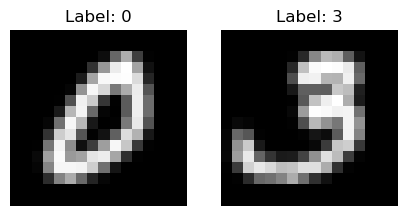

In [34]:
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# plot some images
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].view(image_size, image_size).numpy(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

In [42]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(image_size * image_size, 32, bias=True))
        self.layers.append(nn.Linear(32, 32, bias=True))
        self.layers.append(nn.Linear(32, 32, bias=True))
        self.layers.append(nn.Linear(32, 32, bias=True))
        self.layers.append(nn.Linear(32, 32, bias=True))
        self.layers.append(nn.Linear(32, 10, bias=True))
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.normal_(layer.bias)

    def forward(self, x):
        x = x.view(-1, image_size * image_size)
        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.relu(x)
        output = self.layers[-1](x)
        return output

model = MLP()

In [ ]:
def plane_samples(images, domain_bounds=[-1, 1], n_samples=500, return_xy=False):
    """ 
    Define the plane going through the three images images[0], images[1], images[2].
    Sample n_samples points on the plane, within the domain bounds.
    return_xy: only useful for the plot later.
    """
    x1 = torch.linspace(domain_bounds[0], domain_bounds[1], n_samples)
    x2 = torch.linspace(domain_bounds[0], domain_bounds[1], n_samples)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2, indexing='xy')

    basis = torch.concatenate((images[0] - images[1], images[0] - images[2]), dim=1).T
    plane = grid_x1.reshape((n_samples, n_samples, 1)) * basis[0] + grid_x2.reshape((n_samples, n_samples, 1)) * basis[1]
    plane = plane + images[0].view(-1, image_size * image_size)
    if return_xy:
        return plane, x1, x2
    else:
        return plane

def count_regions(model, plane, return_inverse=True):
    """
    Count the number of regions in the plane defined by the three images.
    return_inverse: only useful for the plot later.
    """
    n_px = plane.shape[2]           # number of pixels per image
    n_samples = plane.shape[0]
    x = plane.reshape((n_samples * n_samples, n_px))

    activations = []
    layers = model.layers
    for l in range(len(layers)-1):
        with torch.no_grad():
            x = layers[l](x)
            x = model.relu(x)
            activations.append( (x>0).squeeze().int() )
    activations = torch.cat(activations, dim=1)
    print(activations.shape)
    
    unique_activations, inverse_indices = torch.unique(activations, dim=0, return_inverse=True)
    n_regions = len(unique_activations)
    if return_inverse:
        return n_regions, inverse_indices
    else:
        return n_regions

# Test the function
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images[:3]

plane = plane_samples(images)
n_regions, _ = count_regions(model, plane)
print(f"(Estimated) number of regions: {n_regions}")

torch.Size([250000, 32])
torch.Size([250000, 32])
torch.Size([250000, 32])
torch.Size([250000, 32])
torch.Size([250000, 32])
torch.Size([250000, 32])
torch.Size([250000, 32])
torch.Size([250000, 32])
torch.Size([250000, 32])
torch.Size([250000, 32])
torch.Size([250000, 160])
(Estimated) number of regions: 1757


Training takes 3min without counting. Approx. same with counting.

In [44]:
# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
total_step = len(train_loader)
plane = plane_samples(images, domain_bounds=[-1.5, 0.5], n_samples=1000)
n_regions = []      # Count the number of regions at each epoch
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item()}")

    n_region = count_regions(model, plane, return_inverse=False)
    n_regions.append(n_region)

Epoch [1/20], Step [100/600], Loss: 1.7711666822433472
Epoch [1/20], Step [200/600], Loss: 0.831663966178894
Epoch [1/20], Step [300/600], Loss: 0.4231828451156616
Epoch [1/20], Step [400/600], Loss: 0.3960820436477661
Epoch [1/20], Step [500/600], Loss: 0.4233512878417969
Epoch [1/20], Step [600/600], Loss: 0.5219312906265259
Epoch [2/20], Step [100/600], Loss: 0.29151859879493713
Epoch [2/20], Step [200/600], Loss: 0.3599128723144531
Epoch [2/20], Step [300/600], Loss: 0.43724682927131653
Epoch [2/20], Step [400/600], Loss: 0.13939498364925385
Epoch [2/20], Step [500/600], Loss: 0.22880157828330994
Epoch [2/20], Step [600/600], Loss: 0.3591998219490051
Epoch [3/20], Step [100/600], Loss: 0.21417909860610962
Epoch [3/20], Step [200/600], Loss: 0.2636834383010864
Epoch [3/20], Step [300/600], Loss: 0.1869071125984192
Epoch [3/20], Step [400/600], Loss: 0.1666000932455063
Epoch [3/20], Step [500/600], Loss: 0.17279380559921265
Epoch [3/20], Step [600/600], Loss: 0.16090993583202362
Epoc

### Checks and visuals

In [45]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Accuracy of the model on the 10000 test images: {100 * correct / total}%")

Accuracy of the model on the 10000 test images: 96.69%


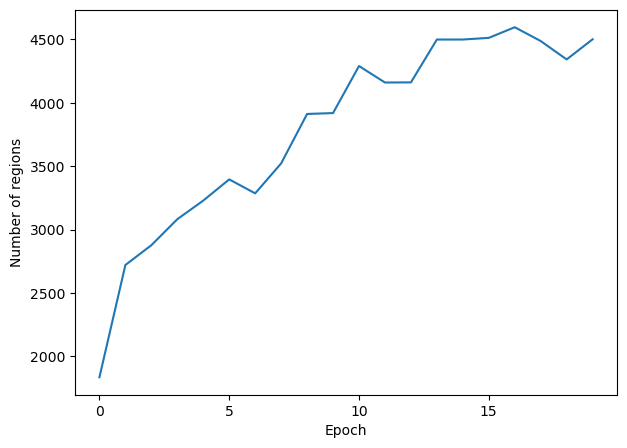

In [46]:
def plot_evolution_regions(n_epochs: int, n_regions: np.ndarray):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(np.arange(n_epochs), n_regions)
    plt.xlabel('Epoch')
    plt.ylabel('Number of regions')
    plt.xticks(np.arange(n_epochs, step=5))
    plt.show()

plot_evolution_regions(num_epochs, n_regions)

Locator attempting to generate 3195 ticks ([0.0, ..., 3194.0]), which exceeds Locator.MAXTICKS (1000).


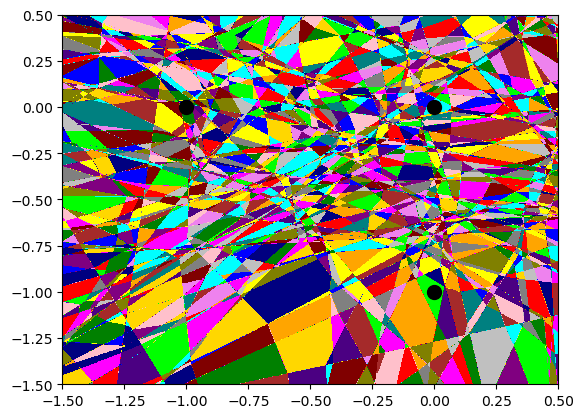

In [47]:
def plot_partition(model, images, n_samples, domain_bounds=[-1, 1]):
    color_set = [
        "blue", "green", "yellow", "orange", "red", "purple", "cyan", "magenta",
        "brown", "pink", "lime", "teal", "navy", "gold", "silver", "gray",
        "maroon", "olive", "violet", "indigo"
    ]
    plane, x1, x2 = plane_samples(images, n_samples=n_samples, domain_bounds=domain_bounds, return_xy=True)
    n_regions, inverse_indices = count_regions(model, plane, return_inverse=True)
    unique_values = torch.unique(inverse_indices).tolist()
    color_map = {val: random.choice(color_set) for val in unique_values}

    plt.contourf(
        x1.numpy(), x2.numpy(),
        np.array(inverse_indices).reshape(n_samples, n_samples),
        colors=[color_map[val] for val in unique_values],
        levels=len(unique_values),
        extend='neither'
    )
    plt.scatter(
        np.array([0, -1, 0]), np.array([0, 0, -1]),
        color='black', marker='o', s=100
    )
    plt.show()

plot_partition(model, images, n_samples=1000, domain_bounds=[-1.5, 0.5])

- We need to refine a lot the n_samples for the number of regions to converge. Might be expensive. -> Try incorporating the asymptotic regression in the couting.
- Plot of the input space partition is not satisfactory. It seems the region almost all converge to the center. There is no reason for this to be true. Need to understand why this happens. -> Can check this in the toy example.
- Number of regions evolution during training doesn't look like the paper. Need to check this, understand why. Reproduce the results from the paper.
- Generate the partition plot before training to check if you do the same observation as in the paper.
- Look at repo LRCount to understand how they count the number of regions.
- Undestand better the plane equation. Why does it change if you add x2 instead of x1. Or x3? Try in R^3 to visualize everything. In particular, make sure the black dots really correspond to the three images.

Center of the image corresponds to the point parametrized as (0,0) in the plane, i.e. to images[0].

Asymptotic number of regions (after training): 7.374220244445715


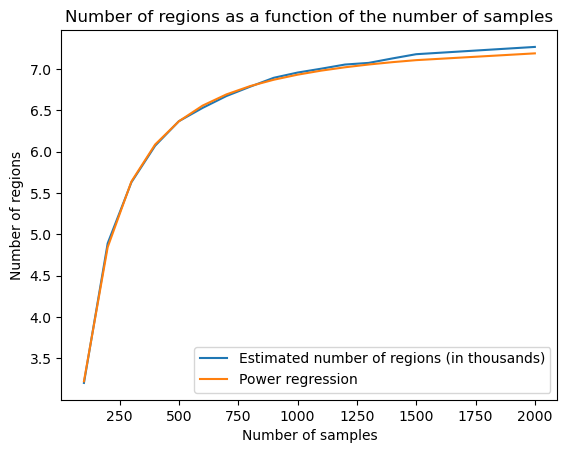

In [27]:
n_samples = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 2000]
n_regions_estimator = []
for n in n_samples:
    plane = plane_samples(images, n_samples=n, domain_bounds=[-1.5, 0.5], return_xy=False)
    n_region = count_regions(model, plane, return_inverse=False)
    n_regions_estimator.append(n_region)

n_regions_estimator = np.array(n_regions_estimator)/1000

# Asymptotic regression
def power_regression(x, a, b, n):
    return a * x ** n  / (x ** n + b)

popt, pcov = curve_fit(power_regression, n_samples[:10], n_regions_estimator[:10], p0=[10, 200, 1])
print(f"Asymptotic number of regions (after training): {popt[0]}")

plt.plot(n_samples, n_regions_estimator, label='Estimated number of regions (in thousands)')
plt.plot(n_samples, power_regression(np.array(n_samples), *popt), label='Power regression')
plt.xlabel("Number of samples")
plt.ylabel("Number of regions")
plt.title("Number of regions as a function of the number of samples") 
plt.legend()    
plt.show()